Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
# make a compy of train in case it gets corrupted
train_cp = train.copy()

In [5]:
import numpy as np

def engineerFeatures(df):
    
    df["date_recorded_datetime"] = pd.to_datetime(df["date_recorded"])

    df["date_recorded_epoch"] = df["date_recorded_datetime"].astype(np.int64)
    df["date_recorded_month"] = df["date_recorded_datetime"].apply(lambda x: x.month)
    df["date_recorded_year"] = df["date_recorded_datetime"].apply(lambda x: x.year).astype(np.object)

    df["construction_year_na"] = (df["construction_year"] == 0).apply(lambda x: 1 if x else 0)

    df["age"] = df["date_recorded_year"] - df["construction_year"].apply(lambda x: x if x > 0 else 3000)
    df["age"] = df["age"].apply(lambda x: x if x > 0 else df["age"].median())

    df["nan_count"] = df.replace({"unknown": np.NaN}).isnull().sum(axis=1)
    
    df["age_brackets"] = pd.cut(df["age"], [0, 1, 4, 16, 999], labels=[str(x) for x in range(4)]).astype(np.object)
    for col in ["funder", "wpt_name", "region", "management", "source", "installer"]:
        df["age_brackets_by_"+col] = df["age_brackets"] + "_" + df[col]
        

engineerFeatures(train)
engineerFeatures(test)

engineered = train.copy()

In [7]:
# re-import everything so we have it in one place
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer

from sklearn.feature_selection import SelectKBest

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score

train = engineered.copy()

target = "status_group"

bad_cols = [
    "id",
    "scheme_name",
    "date_recorded",
    "date_recorded_datetime",
    "construction_year",
    "management_group",
    "payment_type",
    "quantity_group",
    "source_type",
    "waterpoint_type_group",
    "extraction_type_group",
    "extraction_type_class",
    "region_code",
    "district_code",
    "wpt_name",
    "management",
]

features = train.columns.drop([target] + bad_cols)


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor

class CustomImputer(SimpleImputer):

    def __init__(self):
        self.__col_to_reg = {}
    

    def fit(self, *args, **kwargs):

        df = args[0]
        self.__col_to_reg = {}

        for col in df.columns:
            features = df.columns.drop(col)
            target = col

            reg = DecisionTreeRegressor()
            reg.fit(df[features], df[col])

            self.__col_to_reg[col] = reg
        
        return df
        

    def transform(self, *args, **kwargs):

        df = args[0]
        df = df.copy()

        for col in df.columns[df.isna().any()]:

            features = df.columns.drop(col)

            reg = self.__col_to_reg[col]
            df[col] = reg.predict(df[features])*df[col].isnull().astype(np.int64) + df[col]*(~(df[col].isnull()).astype(np.int64))
        
        return df

    
    def fit_transform(self, *args, **kwargs):
        df = args[0]

        self.fit(df)
        return self.transform(df)


In [28]:
from sklearn.feature_selection import f_regression, f_classif, SelectKBest
from sklearn.preprocessing import OrdinalEncoder

trn, val = train_test_split(train)

X_train = trn[features]
y_train = trn[target]

X_val = val[features]
y_val = val[target]

enc = ce.OrdinalEncoder()

enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    CustomImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=32),
    RandomForestClassifier(n_jobs=-1, n_estimators=497),
)

In [29]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)

/home/cowley/venv/lambda/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cowley/venv/lambda/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/cowley/venv/lambda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/cowley/venv/lambda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/cowley/venv/lambda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/cowley/v

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_train)

array([[17085,     0,     0],
       [    0, 24249,     1],
       [    1,     1,  3213]])

In [31]:
y_pred = pipeline.predict(X_val)
confusion_matrix(y_pred, y_val)

array([[4470,  718,  157],
       [1189, 7101,  582],
       [  79,  190,  364]])

In [32]:
from sklearn.utils.multiclass import unique_labels

labels = unique_labels(y_val)

columns = ["predicted " + s for s in ["functional", "functional needs repair", "non functional"]]
index = ["actual " + s for s in ["functional", "functional needs repair", "non functional"]]

df = pd.DataFrame(confusion_matrix(y_pred, y_val), columns=columns, index=index)
df.head()

,predicted functional,predicted functional needs repair,predicted non functional
actual functional,4470,718,157
actual functional needs repair,1189,7101,582
actual non functional,79,190,364


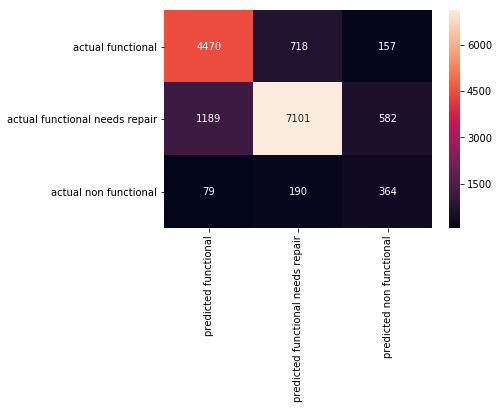

In [33]:
import seaborn as sns

sns.heatmap(df, fmt="d", annot=True)

In [34]:
true_pos = 7101 + 582 + 190 + 364
false_pos = 718 + 157

precision = true_pos / (true_pos + false_pos)

false_negative = 79 + 1189
recall = true_pos / (true_pos + false_negative)

print(precision, recall)


0.903972783143108 0.8665965281430826
